## logic regreesion

In [3]:
# Models used are XGBoost, LightGBM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#import xgboost as xgb
#import lightgbm as lgb
!pip install xgboost
!pip install lightgbm 
!pip install shap
import shap


In [4]:
# --- Load & Preprocess Data ---
df_orig = pd.read_csv(r"C:\Users\lenovo\AmesHousing.csv")
df_orig.drop(['PID', 'Order'], axis=1, inplace=True)
df_orig.head()
df_orig.describe()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,2929.000000,2929.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,442.629566,49.722431,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,455.590839,169.168476,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,370.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,734.000000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [5]:
# Handle missing values
def preprocess_data(df):
    # Drop columns with >80% missing values
    threshold = 0.80
    missing_percent = df.isnull().mean()
    cols_to_drop = missing_percent[missing_percent > threshold].index.tolist()
    df = df.drop(columns=cols_to_drop)
    
    # Impute missing values
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    return df

df_cleaned = preprocess_data(df_orig)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17644\317172645.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17644\317172645.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [6]:
# One-Hot Encoding for categorical variables
categorical_cols = df_cleaned.select_dtypes(include='object').columns.tolist()
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

### Linear Regression Model
This section covers training and evaluating a linear regression model to predict housing prices. It includes error metrics like MAE, RMSE, and R² score.

In [8]:
# Train/Test Split
X = df_encoded.drop(columns=['SalePrice'])
y = df_encoded['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Encode categorical variables
df_encoded = df_cleaned.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# 2. Prepare input and output
X = df_encoded.drop('SalePrice', axis=1)
y = df_encoded['SalePrice']

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 5. Make predictions
y_pred = lr_model.predict(X_test)

# 6. Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 7. Print results
print("Linear Regression Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Linear Regression Model Performance:
MAE: 20191.10
RMSE: 33373.65
R² Score: 0.8611


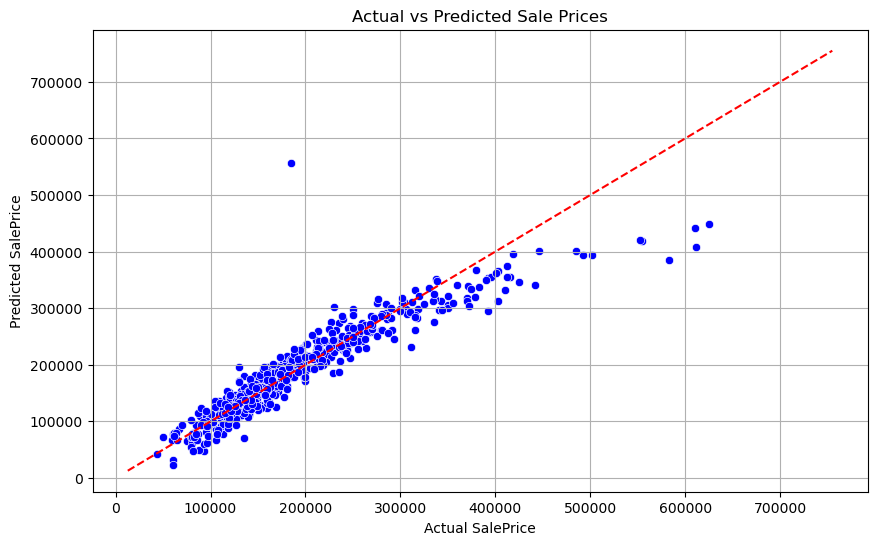

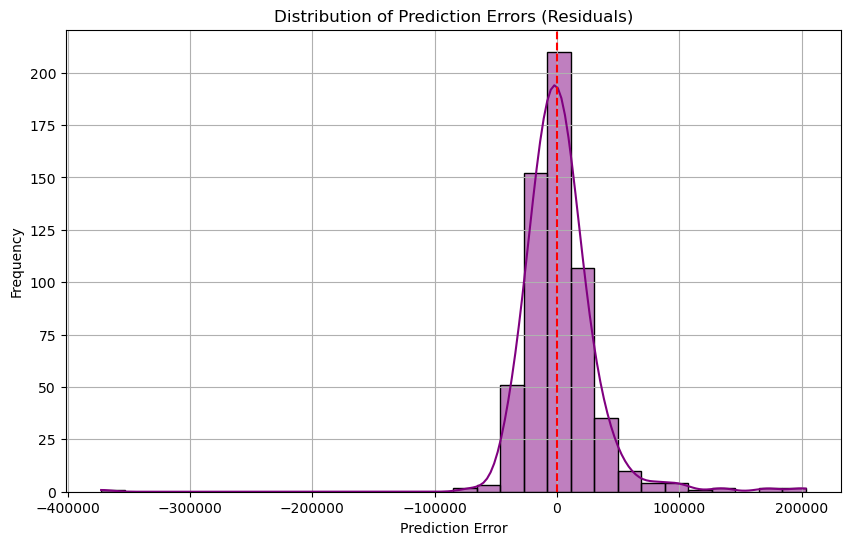

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prediction vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color="blue")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Ideal line
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted Sale Prices")
plt.grid(True)
plt.show()

# Residuals distribution
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True, color="purple")
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Actual vs Predicted Sale Price
A scatter plot that compares actual sale prices with predicted values. Points near the red line indicate better model performance.

  0%|          | 0/586 [00:00<?, ?it/s]

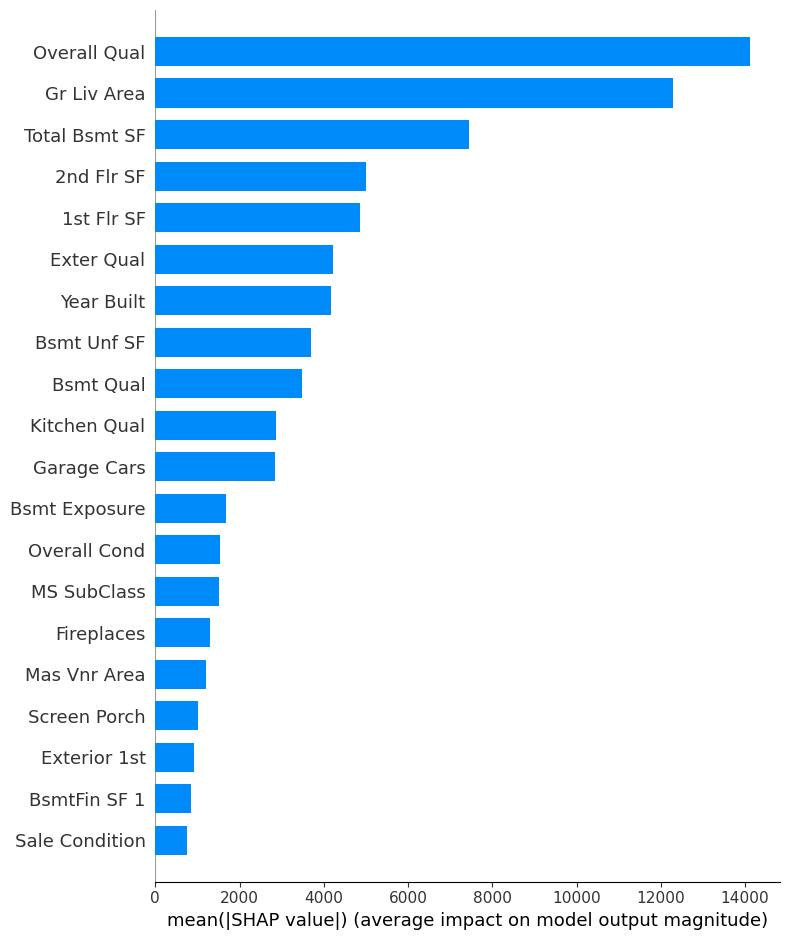

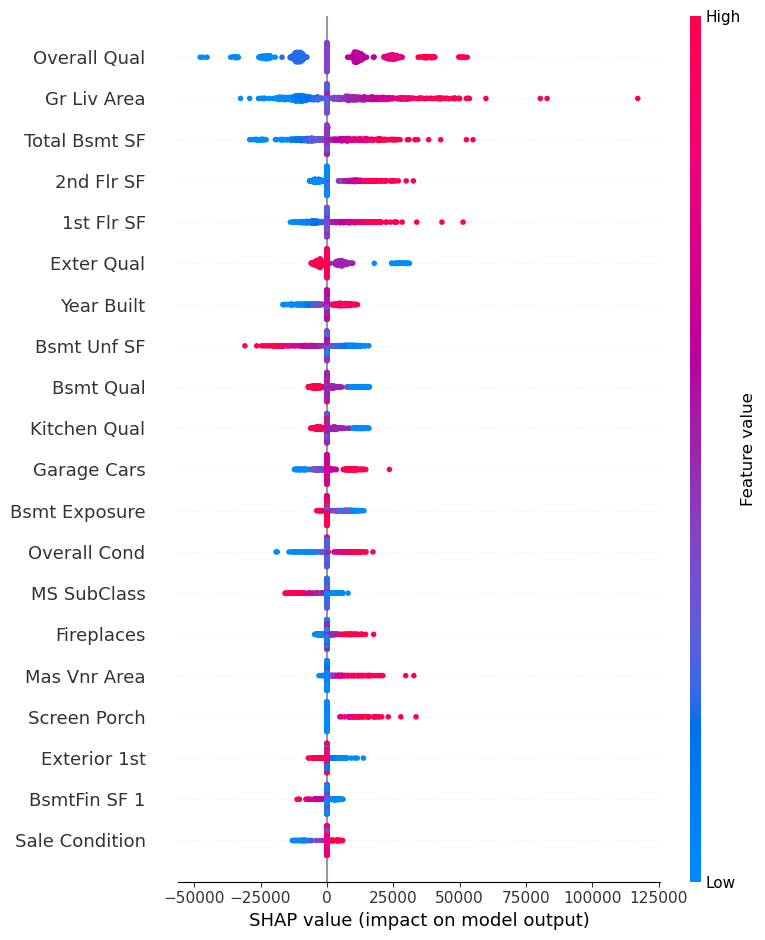

In [12]:
import shap

# For linear models, use KernelExplainer
# Sample a few rows for background (speed)
background = shap.sample(X_train, 100, random_state=42)

explainer = shap.KernelExplainer(lr_model.predict, background)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Optional: SHAP beeswarm plot (shows direction and magnitude)
shap.summary_plot(shap_values, X_test)


### Residuals Distribution
Histogram showing the difference between predicted and actual values. A centered and narrow distribution indicates good model accuracy.

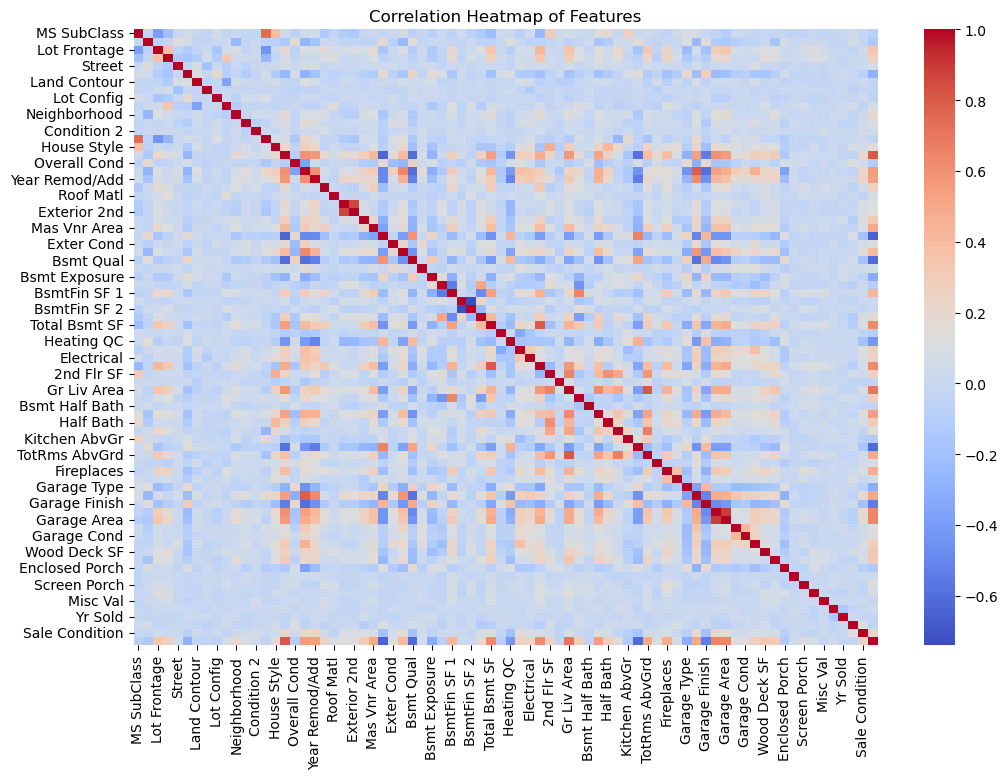

In [14]:

# --- Correlation Heatmap ---
plt.figure(figsize=(12, 8))
corr_matrix = df_encoded.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Features")
plt.show()


### SHAP Value Explanation
SHAP values help interpret model predictions by showing how each feature contributes to the output.

### Correlation Heatmap
Displays pairwise correlation between numerical features. Useful for spotting multicollinearity.

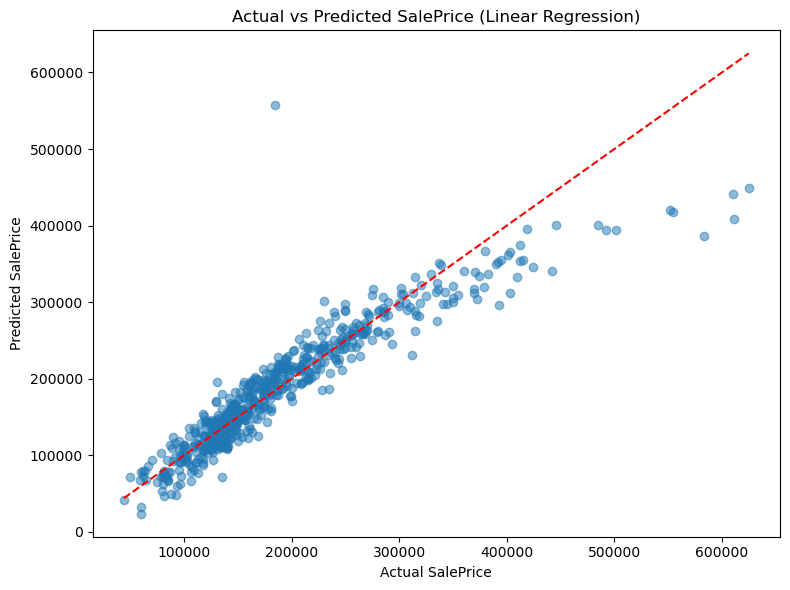

In [17]:

# --- Actual vs Predicted Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice (Linear Regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()


### Feature Importance
Shows the top 10 features that most influence the predictions based on the model's learned coefficients.

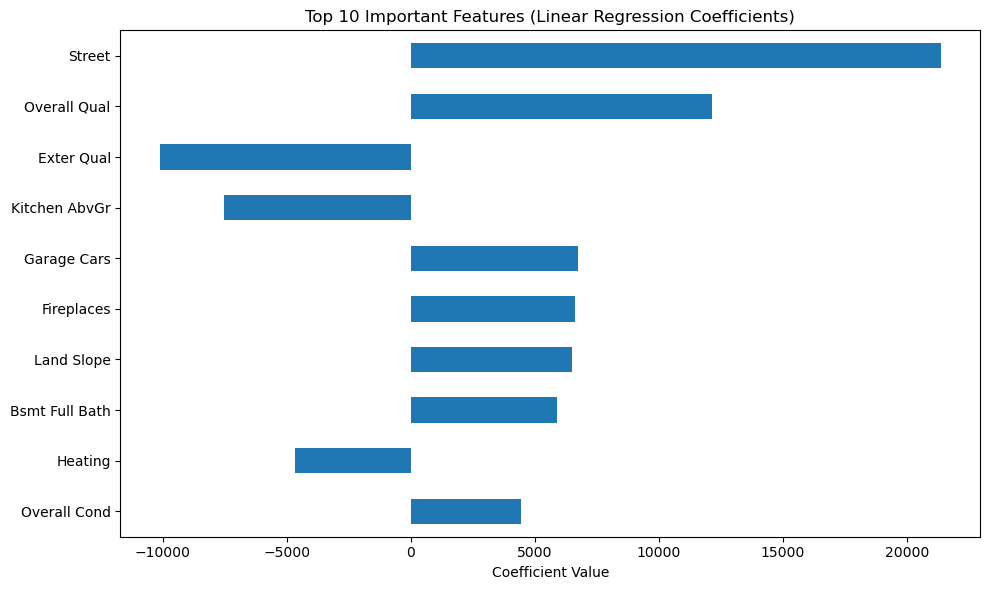

In [19]:

# --- Feature Importance from Coefficients ---
importance = pd.Series(lr_model.coef_, index=X.columns)
importance_sorted = importance.sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
importance_sorted.head(10).plot(kind='barh')
plt.title("Top 10 Important Features (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
